In [1]:
import streamlit as st
import pickle
import math
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import cm
import matplotlib.pyplot as plt

from PIL import Image
import json
from urllib.request import urlopen

from lime.lime_tabular import LimeTabularExplainer

2022-06-21 12:33:42.624 INFO    numexpr.utils: NumExpr defaulting to 8 threads.


In [2]:
st.set_page_config(layout="wide")

In [3]:
modelpath = 'MODELS/'
pickle.load(open(modelpath+"xgboost.pkl",'rb'))

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, ...),
             param_grid={'learning_rate': [0.1, 0.2], 'n_estimators': [100],
                         'subsample': [0.7, 0.8]},
             scoring='roc_auc', verbose=-1)

In [59]:
def load_data(path,filename):
    data = pd.read_csv(path+filename)
    list_id = data['SK_ID_CURR'].tolist()
    return list_id,data

def load_model(modelname):

    modelpath = 'MODELS/'
    modelname = modelname.replace(" ","")

    if modelname == 'lightGBM':
        return pickle.load(open(modelpath+"lightGBM.pkl",'rb'))
    elif modelname == 'XGBoost':
        return pickle.load(open(modelpath+"xgboost.pkl",'rb'))
    
    else:
        return pickle.load(open(modelpath+"RandomForest.pkl",'rb'))
    

def plot_features_importances(dataframe,modelname):

    model = load_model(modelname)

    cols = dataframe.drop(['SK_ID_CURR','TARGET'],axis=1).columns
    importances = model.best_estimator_.feature_importances_
    features_importances = pd.concat((pd.DataFrame(cols, columns = ['Variable']), 
                                     pd.DataFrame(importances, columns = ['Importance'])), 
                                    axis = 1).sort_values(by='Importance', ascending = False)

    cols = features_importances[["Variable", "Importance"]].groupby("Variable").mean().sort_values(by="Importance", ascending=False)[:40].index
    best_features = features_importances.loc[features_importances.Variable.isin(cols)]
    fig=plt.figure(figsize=(8, 10))
    sns.barplot(x="Importance", y="Variable", data=best_features.sort_values(by="Importance", ascending=False))

    #plt.title("Importance des variables",fontsize=40)
    plt.xlabel("Importance",fontsize=18)
    plt.ylabel("Variable",fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=14)
    st.pyplot(fig)

    return features_importances

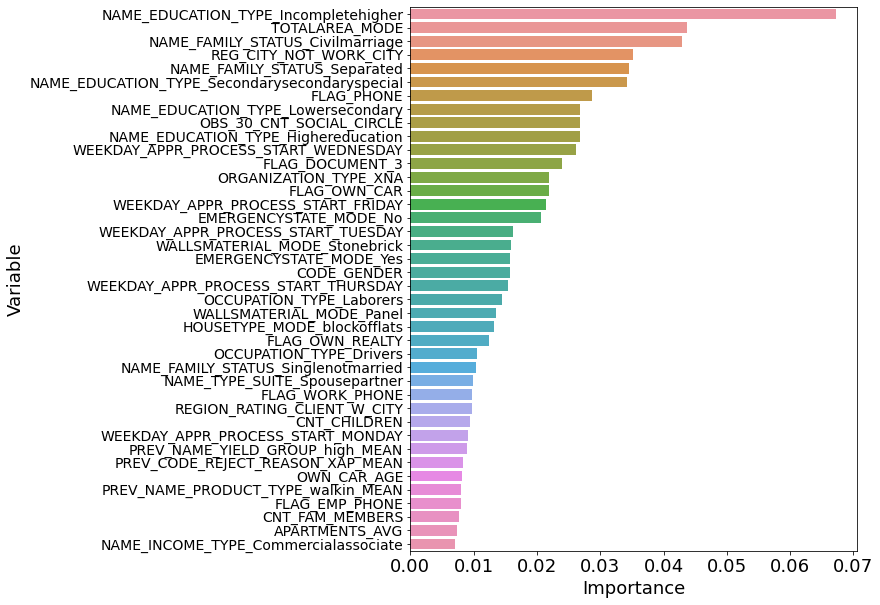

In [79]:
features_importances=plot_features_importances(df,"XGBoost")

In [75]:
data=pd.read_csv("app_train.csv")

In [76]:
write_client_info(df["SK_ID_CURR"][0],data)

(25, 'M', 'Single / not married', 0.0, 202500.0, 406597.5)

In [81]:
get_local_interpretation(df["SK_ID_CURR"][0],df,"XGBoost",features_importances)

Intercept 0.5211388161239985
Prediction_local [0.04259025]
Right: 0.5241204
Intercept 0.4788611897275618
Prediction_local [0.95740975]
Right: 0.4758796


In [80]:
def write_client_info(ID_client,app_train):

    def amount_formatter(amount):

        x = round(amount)
        x = "{:,.2f}".format(x)
        x = x.split(".")[0]
        x = x.replace(","," ")

        return x
    list_infos = ['SK_ID_CURR','NAME_CONTRACT_TYPE','CODE_GENDER','FLAG_OWN_CAR',
                  'FLAG_OWN_REALTY','CNT_CHILDREN','AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY',
                  'NAME_INCOME_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','DAYS_BIRTH','DAYS_EMPLOYED',
                  'CNT_FAM_MEMBERS','WEEKDAY_APPR_PROCESS_START','HOUR_APPR_PROCESS_START']

    X = app_train[list_infos]
    client_infos = X[X['SK_ID_CURR'] == int(ID_client)]

    st.text("")
    st.header("Informations descriptives du client:")
    st.text("")

    cls1,cls2 = st.beta_columns(2)

    age = int(np.abs(client_infos['DAYS_BIRTH'].tolist()[0])/365)
    genre = str(client_infos['CODE_GENDER'].tolist()[0])
    situation_familiale = str(client_infos['NAME_FAMILY_STATUS'].tolist()[0])
    nb_enfants = client_infos['CNT_CHILDREN'].tolist()[0]
    revenus_total = client_infos['AMT_INCOME_TOTAL'].tolist()[0]
    montant_credit = client_infos['AMT_CREDIT'].tolist()[0]
    cnt_fam_members = int(client_infos['CNT_FAM_MEMBERS'].tolist()[0])
    amt_annuity = client_infos['AMT_ANNUITY'].tolist()[0]
    name_contract_type = client_infos['NAME_CONTRACT_TYPE'].tolist()[0]

    with cls1:
        st.write("**IDentifiant: **"+str(ID_client))
        st.write("**Age: **"+str(age)+" ans")
        st.write("**Genre: **"+genre)
        st.write("**Situation familiale: **"+situation_familiale)
        st.write("**Nombre d'enfants: **"+str(nb_enfants))

    with cls2:
        st.write("**Composition de la famille: **"+str(cnt_fam_members))
        st.write("**Révenus total: **"+str(amount_formatter(revenus_total))+" $")
        st.write("**Montant du crédit: **"+str(amount_formatter(montant_credit))+" $")
        st.write("**Annuité: **"+str(amount_formatter(amt_annuity))+" $")
        st.write("**Type de prêt: **"+str(name_contract_type))

    return age,genre,situation_familiale,nb_enfants,revenus_total, montant_credit

def plot_client_stats(ID_client,dataframe,filters):

    cols = ["SK_ID_CURR","Age","CODE_GENDER","CNT_CHILDREN","AMT_INCOME_TOTAL",
            "AMT_CREDIT","NAME_FAMILY_STATUS"]

    data = dataframe[cols]

    X = data[data['SK_ID_CURR'] == int(ID_client)]
    new_data = data[data['SK_ID_CURR'] != int(ID_client)]

    if filters == "Age":
        new_data = new_data[new_data['Age'] == X['Age'].values[0]]

    if filters == "Sexe":
        new_data = new_data[new_data['CODE_GENDER'] == X['CODE_GENDER'].values[0]]

    fam_status = new_data[new_data['NAME_FAMILY_STATUS'] == X['NAME_FAMILY_STATUS'].values[0]]

    columns=["Client","Médiane/dataset","Médiane/Status"]

    amt_income_total = pd.concat((pd.DataFrame(columns, columns = ['labels']), 
                          pd.DataFrame([X['AMT_INCOME_TOTAL'].values[0],
                                        new_data['AMT_INCOME_TOTAL'].median(),
                                        fam_status['AMT_INCOME_TOTAL'].median(),],
                                       columns = ['Values'])),axis = 1)

    fig = plt.figure(figsize=(7, 2), dpi= 80, facecolor='w', edgecolor='k')

    ax1 = plt.subplot(1,3,1)
    sns.barplot(x="labels", y="Values", data=amt_income_total,ax=ax1)
    plt.xticks(rotation=90)
    plt.title("Revenu total")

    amt_credit = pd.concat((pd.DataFrame(columns, columns = ['labels']), 
                          pd.DataFrame([X['AMT_CREDIT'].values[0],
                                        new_data['AMT_CREDIT'].median(),
                                        fam_status['AMT_CREDIT'].median(),],
                                       columns = ['Values'])),axis = 1)
    ax2 = plt.subplot(1,3,2)
    sns.barplot(x="labels", y="Values", data=amt_credit,ax=ax2)
    plt.xticks(rotation=90)
    plt.title("Montant du crédit")

    cnt_children = pd.concat((pd.DataFrame(columns, columns = ['labels']), 
                          pd.DataFrame([X['CNT_CHILDREN'].values[0],
                                        new_data['CNT_CHILDREN'].median(),
                                        fam_status['CNT_CHILDREN'].median(),],
                                       columns = ['Values'])),axis = 1)

    ax3 = plt.subplot(1,3,3)
    sns.barplot(x="labels", y="Values", data=cnt_children,ax=ax3)
    plt.xticks(rotation=90)
    plt.title("Nombre d'enfants")

    plt.subplots_adjust(wspace=0.9)

    st.pyplot(fig)

    return True